# Grammar Error Correction

In [2]:
! pip install jsonlines

In [3]:
import pandas as pd
import numpy as np
import os
import jsonlines
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Business Problem:
<p>
The problem that we are dealing with is known as <b>Grammer Error Correction Problem</b>. As the name suggests the given an input sentence in false English (here we are dealing with English Language) we have to predict the correct sentence which interprets the same meaning as the input sentence. 
</p>

<h><b>Applications</b></h>

* The problem has a huge application in our day to day practices. As writing a text is quite a prominent way of sharing information and considering the fact that time is valuable to everybody so this model could assist the writer to write efficiently in a reduces time and effort. 


* Moreover, there are not many individuals who a fluent with english language. These kinds of models make sure that language does not become a barrier in sharing ideas or knowledge. This will make sure that the reader and the writer are both on the same page. 


### Performance Metric:
As we are going to deal the problem as a sequenc to sequence problem therefore that the metric that we would be using here is   **BELU score**.
#### BELU score or Bilingual Evaluation Understudy
* This is a metric which is used to compare two sentences and gives a score based on the match. The perfect match give tha score of 1  and perfect unmatct gives a value of 0.
* It is widely used due to is simplicity and coorelation with human evaluation.For more info refer :
https://machinelearningmastery.com/calculate-bleu-score-for-text-python/


### Datasets
The problem of this kind requires a high quality datasets which is very rarely available. After the literature survey we have narrowed down the datasets to two sources
* Lang-8
* NUS Social Media Text Normalization and Translation Corpus


We would be combining both the datasets to train out model.

##### NOTE : I have analysed the Github dataset also it is mosltly related to code related sentence which is not required for our problem. Therefore, I am not considering that dataset.

## Dataset1 : Lang-8


Ref: https://en.wikipedia.org/wiki/Lang-8.com
<p>
This is website, Japanes website to be specific which works towards language learning. Users are able to post in the language(s) they are learning and that post will appear to native speakers of that language for correction. Users are limited to two learning languages. Users can also correct posts written in their native language. The correction feature includes things such as color coding, bold, and strikethrough.
</p>

* So we have got the dataset for this website which contains 2 files train and test.

* The train has different informations as follows:

    - Number of correction
    - Serial number
    - Sentence number
    - 0 is the title
    - Sentence written by a learner of English 
    - Corrected Sentences (If exists)
    
* Out of this we have extracted **input sentence and corrected sentence** pairs for those datapoints for which both these sentences exists.


In [6]:
'''THIS CELL READS THE LANG-8 DATASET FILE AND EXTRACTS INCORRECT AND CORRECT SENTENCES ONLY'''

f1 = open("/content/drive/MyDrive/Colab Notebooks/cs2/lang-8/lang-8-en-1.0/entries.train") # OPENING THE FILE 
lines1 = f1.readlines() # READING THE LINES
inp1 = [] # LIST FOR STORING INCORRECT SENTENCES
tgt1 = [] # LIST FOR STORING

for i in lines1: # FOR EACH LINE 
    lst = i.split("\t") # WE ARE SPLITTING THE LINE AT \t
    
# IF LENGTH OF THE LIST IS GREATER THAN 5 THEN CORRECT SENTTENCE EXISTS OTHERWISE ONLY INCORRECT SENTENCE IS PRESENT 
    if len(lst)>5  :     #IF LENGTH IS GREATER THAN 5  
        inp1.append(lst[-2]) # APPEND SECONG LAST ITEM IN LIST WHICH IS INCORRECT SENTENCE
        tgt1.append(lst[-1]) # APPEND LAST ITEM IN THE LIST WHICH IS CORRECT SENTECE.

### Dataset2 : NUS Social Media Text Normalization and Translation Corpus

This is the dataset by National University of Singapore (NUS) which is a social media data text data. The dataset size is 2000 datapoints.

The data in its raw form has three rows for each datapoint.
* The first row is the social media text
* The second row is the correct formal English translated text
* The third row is the chinese translated data.

Out of these, we can use the first two rows of each datapoint for our problem.

In [7]:
'''THIS CELL READS THE SMS_TEXT DATASET FILE AND EXTRACTS INCORRECT AND CORRECT SENTENCES ONLY'''


f2 = open("/content/drive/MyDrive/Colab Notebooks/cs2/text_sms/release/en2cn-2k.en2nen2cn","r",encoding="UTF-8") # READING THE FILE

lines2 = f2.readlines() # STORING ALL THE LINES IN A VARIABLE
inp2 = [] # LIST FOR STORING INCORRECT SENTENCES
tgt2 = [] # LIST FOR STORING CORRECT SENTENCES

# THE DASET CONTAINS 2000 DATAPOINTS, THEREFORE RUNNING THE LOOP FOR 2000 TIMES
for i in range(2000): 
    inp2.append(lines2[i*3]) #APPEDING FIRST ROW FOR EACH DATAPOINT
    tgt2.append(lines2[i*3+1]) # APPENDING SECOND ROW FOR EACH DATAPOINT

## Combining datasets

In [11]:
'''THIS CELL COMBINES BOTH THE DATASETS TOGETHER'''

df = pd.DataFrame() # CREATING THE DATAFRAME
df["input"] = inp1+inp2 # ADDING BOTH THE LISTS OF INPUTS TO ONE COLUMN
df["output"] =  tgt1+tgt2 # ADDING BOTH THE LISTS OF TARGETS TO ONE COLUMN
df["y"] = list("1"*len(inp1)) + list("2"*len(inp2))

In [12]:
df

,input,output,y
0,And he took in my favorite subject like soccer .,And he took in my favorite subjects like socce...,1
1,"Actually , who let me know about Lang - 8 was ...","Actually , he was the one who let me know abou...",1
2,His Kanji 's ability is much better than me .,His Kanji ability is much better than mine .\n,1
3,"We 've known each other for only half a year ,...","We 've known each other for only half a year ,...",1
4,I heard a sentence last night when I watched TV .,I heard a sentence last night when I was watch...,1
...,...,...,...
511158,Hmmm... Thk i usually book on wkends... Depend...,Hmm. I think I usually book on weekends. It de...,2
511159,ask them got any sms messages to gif me lei......,Can you ask them whether they have for any sms...,2
511160,We r near coca oredi...\n,We are near Coca already.\n,2
511161,hall Eleven. Got lectures le mah.èn forget abt...,Hall eleven. Got lectures. And forget about co...,2


### Data Preprocessing 

In [13]:
'''THIS FUNCTION REMOVES THE SPACES BETWEEN THE CONTRACTED WORDS AND REMOVING UNNECESSARY SPACES IN THE SENTENCES
            ca n't ==> can't 
            I 'm ===> I'm ...etc
'''
def remove_spaces(text):
    text = re.sub(r" '(\w)",r"'\1",text)
    text = re.sub(r" \,",",",text)
    text = re.sub(r" \.+",".",text)
    text = re.sub(r" \!+","!",text)
    text = re.sub(r" \?+","?",text)
    text = re.sub(" n't","n't",text)
    text = re.sub("[\(\)\;\_\^\`\/]","",text)
    
    return text


'''THIS FUNCTION DECONTRACTS THE CONTRACTED WORDS'''
#REF : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


'''THIS FUNCTION PREPROCESSES THE TEXT '''
def preprocess(text):
    text = re.sub("\n","",text)
    text = remove_spaces(text)   # REMOVING UNWANTED SPACES
    text = re.sub(r"\.+",".",text)
    text = re.sub(r"\!+","!",text)
    text = decontract(text)    # DECONTRACTION
    text = re.sub("[^A-Za-z0-9 ]+","",text)
    text = text.lower()
    return text

In [14]:
'''HERE WE ARE APPLYIN PREPROCESS FUNCTION TO INPUT AND OUTPUT SENTENCES'''

df["processed_input"] = df.input.apply(preprocess) # APPLYING PREPROCESS FUNCTION TO INPUT 
df["processed_output"] = df.output.apply(preprocess) # APPLYING PREPROCESS FUNCION TO OUTPUT

In [15]:
df =df.drop(["input","output"],axis=1)

## Exploartory Data Analysis

In [16]:
# TOTAL DATAPOINTS
df.shape

(511163, 3)

In [17]:
'''CHECK FOR NULL VALUES'''

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511163 entries, 0 to 511162
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   y                 511163 non-null  object
 1   processed_input   511163 non-null  object
 2   processed_output  511163 non-null  object
dtypes: object(3)
memory usage: 11.7+ MB


#### Observations:
* There are more than 500k number of datapoints.
* In both input and output columns we can find some null values.

### Removing null values

In [18]:
'''THIS CELL REMOVES ROWS WITH NULL VALUES IN INPUT AND OUTPUT TEXT'''

df = df[df.processed_input.notnull()]
df = df[df.processed_output.notnull()]

#### Observations:
* By removing the null values we have reduced the number of rows from 511163 to 511123

### Removing Duplicates

In [19]:
'''DROPPING THE DUPLICATES'''

df = df.drop_duplicates()
df

,y,processed_input,processed_output
0,1,and he took in my favorite subject like soccer,and he took in my favorite subjects like soccer
1,1,actually who let me know about lang 8 was him,actually he was the one who let me know about ...
2,1,his kanji is ability is much better than me,his kanji ability is much better than mine
3,1,we have known each other for only half a year ...,we have known each other for only half a year ...
4,1,i heard a sentence last night when i watched tv,i heard a sentence last night when i was watch...
...,...,...,...
511158,2,hmmm thk i usually book on wkends depends la,hmm i think i usually book on weekends it depends
511159,2,ask them got any sms messages to gif me leinow...,can you ask them whether they have for any sms...
511160,2,we r near coca oredi,we are near coca already
511161,2,hall eleven got lectures le mahn forget abt co...,hall eleven got lectures and forget about comp...


In [20]:
'''CHECK THE NUMBER OF DATAPOINTS LEFT AFTER REMOVING DUPLICATES'''

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505898 entries, 0 to 511162
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   y                 505898 non-null  object
 1   processed_input   505898 non-null  object
 2   processed_output  505898 non-null  object
dtypes: object(3)
memory usage: 15.4+ MB


#### OBSERVATION:
* By dropping duplicates we can reduce the number of datapoints from 511123 to 505890

### EDA for Input Text

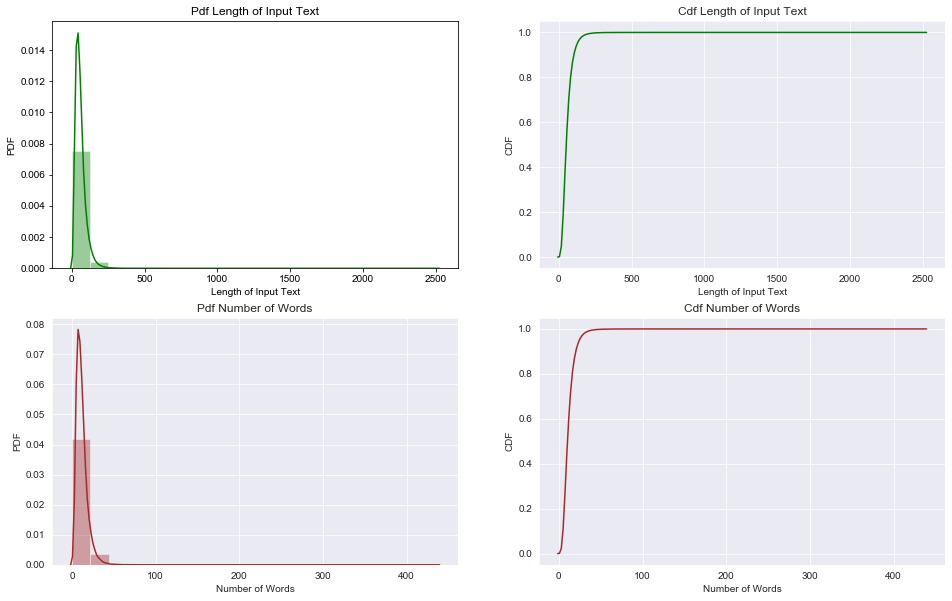

In [ ]:
'''THIS CELL PLOTS THE PDF AND CDF OF LENGTH OF CHARACHERTS AND NUMBER OF WORDS FOR INPUT TEXT'''

# THIS PART OF CODE PLOTS THE PDF OF THE LENTH OF INPUT TEXT
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
sns.set_style("darkgrid")
sns.distplot(df.processed_input.apply(lambda x:len(str(x))),color="green",bins=20)
plt.title("Pdf Length of Input Text")
plt.xlabel("Length of Input Text")
plt.ylabel("PDF")
# THIS PART OF CODE PLOTS THE CDF OF THE LENGTH OF INPUT TEXT
plt.subplot(2,2,2)
sns.kdeplot(df.processed_input.apply(lambda x:len(str(x))),color="green",cumulative=True)
plt.title("Cdf Length of Input Text")
plt.xlabel("Length of Input Text")
plt.ylabel("CDF")
# THIS PART OF CODE PLOTS THE PDF OF NUMBER OF WORDS IN INPUT TEXT
plt.subplot(2,2,3)
sns.distplot(df.processed_input.apply(lambda x: len(str(x).split())),color="brown",bins=20)
plt.title("Pdf Number of Words")
plt.xlabel("Number of Words")
plt.ylabel("PDF")
# THIS PART OF CODE PLOTS THE CDF OF NUMBER OF WORDS IN INPUT TEXT
plt.subplot(2,2,4)
sns.kdeplot(df.processed_input.apply(lambda x: len(str(x).split())),color="brown",cumulative=True)
plt.xlabel("Number of Words")
plt.title("Cdf Number of Words")
plt.ylabel("CDF")
plt.show()

In [ ]:
print('Max Input Length = ',df.processed_input.apply(lambda x:len(str(x))).max())
print("99th Percentile of Number of Characters = ",np.percentile(df_clean.processed_input.apply(lambda x:len(str(x))),99))

Max Input Length =  2519
99th Percentile of Number of Characters =  183.0


In [ ]:
print("Max Input Words = ", df_clean.processed_input.apply(lambda x: len(str(x).split())).max())
print("99th Percentile of Number of Words = ",np.percentile(df_clean.processed_input.apply(lambda x: len(str(x).split())),99))

Max Input Words =  438
99th Percentile of Number of Words =  35.0


#### Obesrvations:
* The distribution for the length of characters and number of words in the input is highly skewed.
* Both the distributons almost follow the same pattern.
* The number of characters in the input could go as high as 2000 and words are upto 400 words.
* The ratio of higher length of words or character is significantly less.
* More than 99 percent of inputs have number of characters less then 200 and number of words less than 50.

## EDA for Output Text

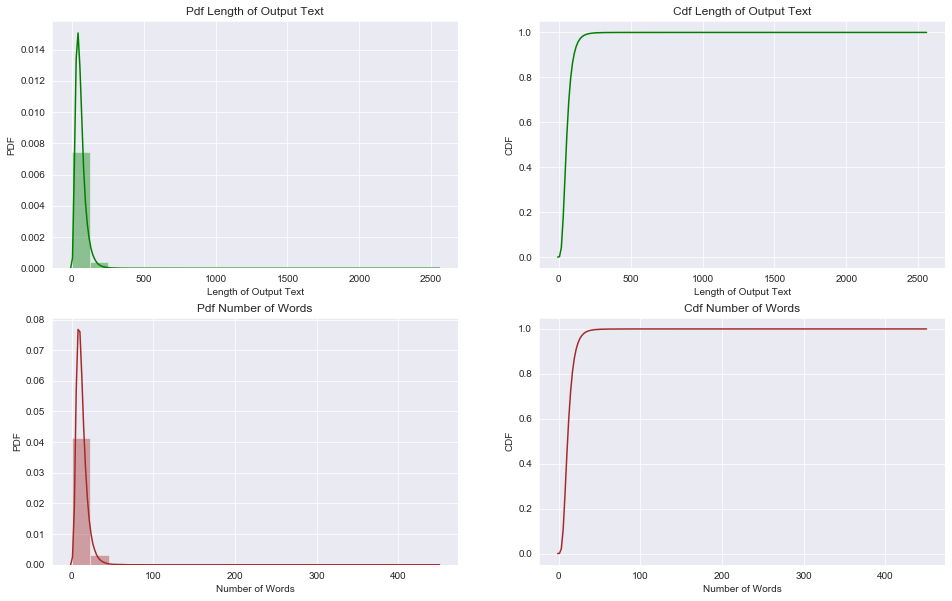

In [ ]:
'''THIS CELL PLOTS THE PDF AND CDF OF LENGTH OF CHARACHERTS AND NUMBER OF WORDS FOR OUTPUT TEXT'''

# THIS PART OF CODE PLOTS THE PDF OF THE LENTH OF OUTPUT TEXT
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
sns.set_style("darkgrid")
sns.distplot(df.processed_output.apply(lambda x:len(str(x))),color="green",bins=20)
plt.title("Pdf Length of Output Text")
plt.xlabel("Length of Output Text")
plt.ylabel("PDF")
# THIS PART OF CODE PLOTS THE CDF OF THE LENGTH OF OUTPUT TEXT
plt.subplot(2,2,2)
sns.kdeplot(df.processed_output.apply(lambda x:len(str(x))),color="green",cumulative=True)
plt.title("Cdf Length of Output Text")
plt.xlabel("Length of Output Text")
plt.ylabel("CDF")
# THIS PART OF CODE PLOTS THE PDF OF NUMBER OF WORDS IN OUTPUT TEXT
plt.subplot(2,2,3)
sns.distplot(df.processed_output.apply(lambda x: len(str(x).split())),color="brown",bins=20)
plt.title("Pdf Number of Words")
plt.xlabel("Number of Words")
plt.ylabel("PDF")
# THIS PART OF CODE PLOTS THE CDF OF NUMBER OF WORDS IN OUTPUT TEXT
plt.subplot(2,2,4)
sns.kdeplot(df.processed_output.apply(lambda x: len(str(x).split())),color="brown",cumulative=True)
plt.xlabel("Number of Words")
plt.title("Cdf Number of Words")
plt.ylabel("CDF")
plt.show()

#### Observation:
* Output text also follows same trend as input.

## WordCoud Analysis for Input Text

In [ ]:
'''THIS CELL FORMS THE CORPUS FOR INPUT TEXT'''


input_corpus="" # PLACEHOLDER

for i in tqdm(df["processed_input"].values): # FOR EACH POINTS IN THE DATASET
   
    input_corpus += " " +str(i) # JOINGING THE SRTING 

100%|████████████████████████████████████████████████████████████████████████| 508898/508898 [00:51<00:00, 9850.20it/s]


In [ ]:
'''THIS CELL FORMS THE WORDCLOUD FOR INPUT TEXT USING THE CORPUS FORMED ABOVE'''

stopword = stopwords.words('english') #STORING THE STOPWORDS 

# FORMING THE WORD CLOUD
wordcloud_input = WordCloud(width = 800, height = 800,
                 background_color ='black',
                 stopwords = stopword,
                 min_font_size = 10).generate(input_corpus)

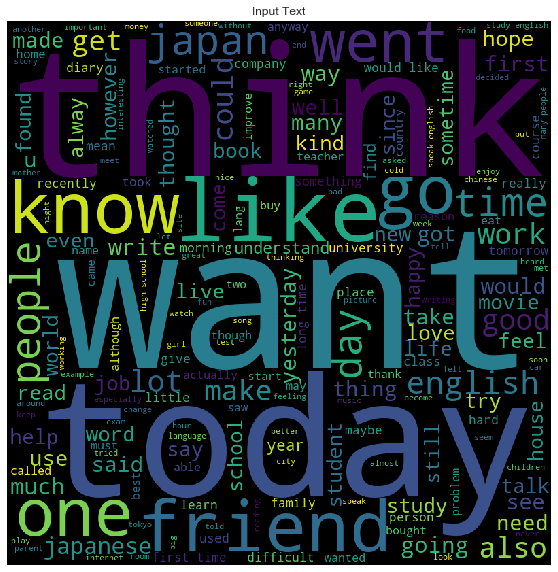

In [ ]:
'''THIS CELL PLOTS THE WORDCLOUD'''

plt.figure(figsize = (16, 10))
plt.imshow(wordcloud_input)
plt.title("Input Text")
plt.axis("off")
plt.show()

## Word Cloud Analysis for Output

In [ ]:
'''THIS CELL FORMS THE CORPUS FOR OUTPUT TEXT'''

# PLACEHOLDER
output_corpus = ""

# FOR EACH POINTS IN THE DATASET
for i in tqdm(df["processed_output"].values):
    # JOINGING THE SRTING 
   
    output_corpus += " " +str(i)

100%|████████████████████████████████████████████████████████████████████████| 508898/508898 [01:09<00:00, 7363.02it/s]


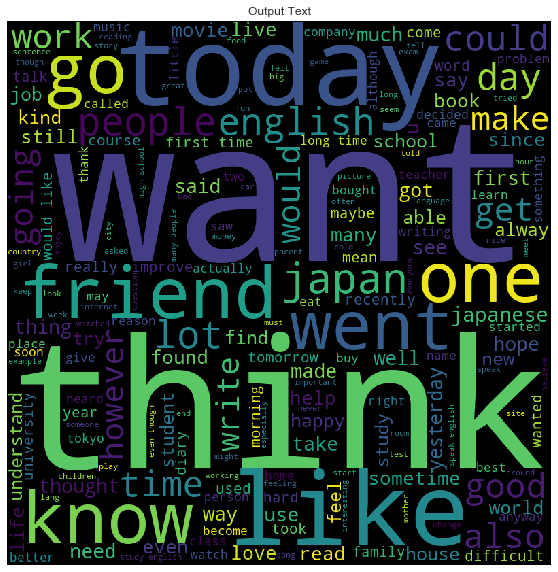

In [ ]:
'''THIS CELL FORMS THE WORDCLOUD FOR OUTPUT TEXT USING THE CORPUS FORMED ABOVE'''

stopword = stopwords.words('english') # STORING THE STOPWORDS

# FORMING THE WORDCLOUD
wordcloud_output = WordCloud(width = 800, height = 800,
                 background_color ='black',
                 stopwords = stopword,
                 min_font_size = 10).generate(output_corpus) 
 
'''PLOTTING THE WORDS CLOUD'''

plt.figure(figsize = (16, 10))
plt.imshow(wordcloud_output)
plt.title("Output Text")
plt.axis("off")
plt.show()

#### Observation :
* The most common words in the input and output text are :
        - think
        - want
        - today
        - Japan
        - English
        

# Wrong words and Corrected words analysis

#####  Wrong words : words present in input but not present in target sentences 
##### Corrected words : words present in target sentences but not present in input sentences.

In [ ]:
'''THIS FUNCTION TAKES IN THE DATAFRAME AND OUPUTS THE CORPUS FOR WRONG WORDS AND CORRECTED WORDS'''

def wrong_words(df):
    # CONVERTING THE SENTENCES OF INPUT TO WORDS AND CONVERTING TO SETS
    inp = df.processed_input.apply(lambda x: set(str(x).split()))
    
    # CONVERTING THE SENTENCES OF OUTPUT TO WORDS AND CONVERTING TO SETS
    out = df.processed_output.apply(lambda x: set(str(x).split()))
    
    # GETTIN THE SET OF WRONG WORDS 
    df_ww = (inp-out).apply(list)
    
    # GETTING THE ST OF CORRECTED SENTENCES
    df_corrected = (out-inp).apply(list)
    
    # JOINING ALL WORDS AND FORIMING A LONG TEXT 
    ww_corpus = ""
    for i in df_ww.values:
        
        if len(i)>0:
            ww_corpus+= " "+ " ".join(i) 
            
    # JOINING ALL WORDS AND FORIMING A LONG TEXT 
    corr_corpus =""       
    for i in df_corrected.values:
        if len(i)>0:
            corr_corpus += " "+ " ".join(i)    
        
    # RETURNING THE WRONG WORDS TEXT AND CORRECTED WORDS TEXT          
    return ww_corpus,corr_corpus

In [ ]:
'''THIS CELL FORMS THE WORD CLOUD FOR WRONG WORDS AND CORRECTED WORDS'''

# GETTING THE TEXT FOR WRONG WORDS AND CORRECTED WORDS
ww_corpus,corr_corpus = wrong_words(df)

# FORMING WORD CLOUD FOR WROND WORDS
wordcloud_ww = WordCloud(width = 800, height = 800,
                 background_color ='black',
                 min_font_size = 10).generate(ww_corpus)

# FORMING WORD CLOUD FOR CORRECTED WORDS
wordcloud_corr = WordCloud(width = 800, height = 800,
                 background_color ='black',
                 min_font_size = 10).generate(corr_corpus)



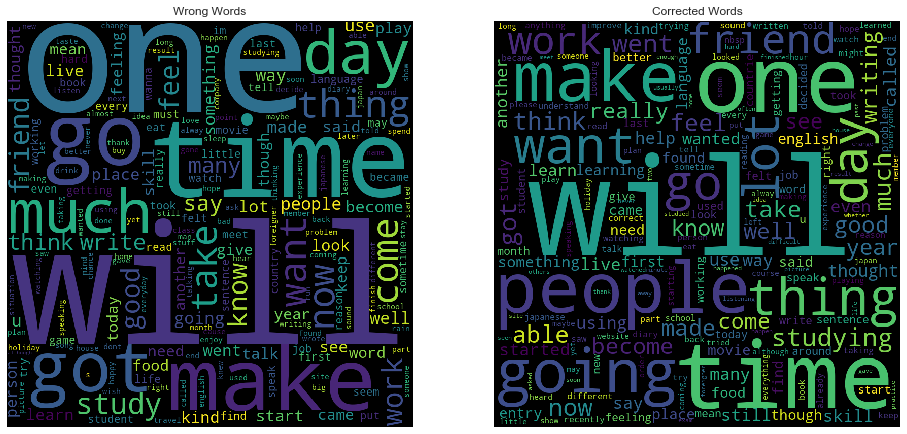

In [ ]:
'''PLOTTING THE WORD CLOUD'''

# PLOTTING WORD CLOUD FOR WRONG WORDS
plt.figure(figsize = (16, 10))
plt.subplot(1,2,1)
plt.imshow(wordcloud_ww)
plt.title("Wrong Words")
plt.axis("off")

# PLOTTING WORD CLOUD FOR CORRECTED WORDS
plt.subplot(1,2,2)
plt.imshow(wordcloud_corr)
plt.title("Corrected Words")
plt.axis("off")
plt.show()

## Observation:
* After observing the incorrect and corrected words images we can observe the change the form of verb that is being used.
    - go ==> going
    - go ==> went
    - study ==> studying
    - use ==> using

## POS Tagging

# Input

In [ ]:
def pos(text):
    pos = nltk.pos_tag(word_tokenize(text))
    pos = [j for i ,j in pos]
    return pos

tags_input = df.processed_input.apply(lambda x: pos(x))
tags_input = [ j for i in tags_input for j in i]
counter_input = Counter(tags_input) 
inp_10 = list(zip(*counter_input.most_common(10)))

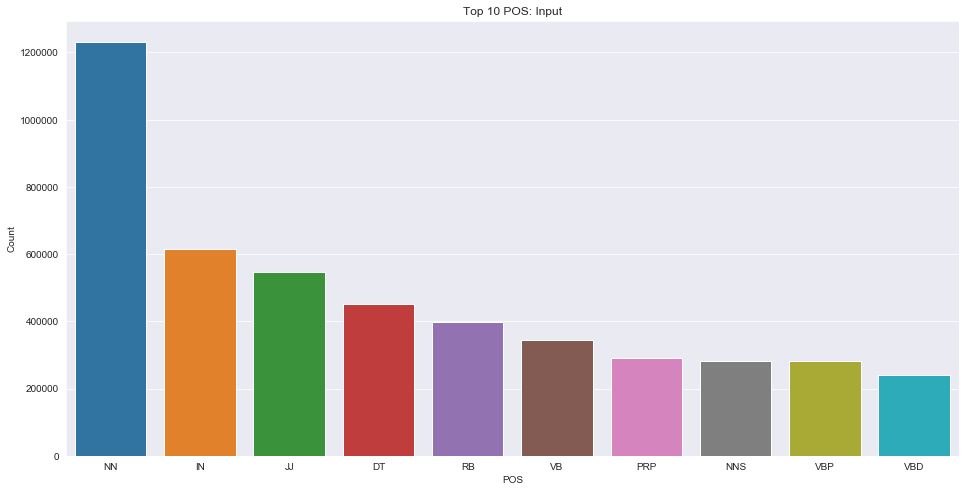

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(x = list(inp_10[0]) , y= list(inp_10[1]))
plt.title("Top 10 POS: Input")
plt.xlabel("POS")
plt.ylabel("Count")
plt.show()

# Output

In [ ]:
def pos(text):
    pos = nltk.pos_tag(word_tokenize(text))
    pos = [j for i ,j in pos]
    return pos

tags_output = df.processed_output.apply(lambda x: pos(x))
tags_output = [ j for i in tags_output for j in i]
counter_output = Counter(tags_output) 
out_10 = list(zip(*counter_output.most_common(10)))

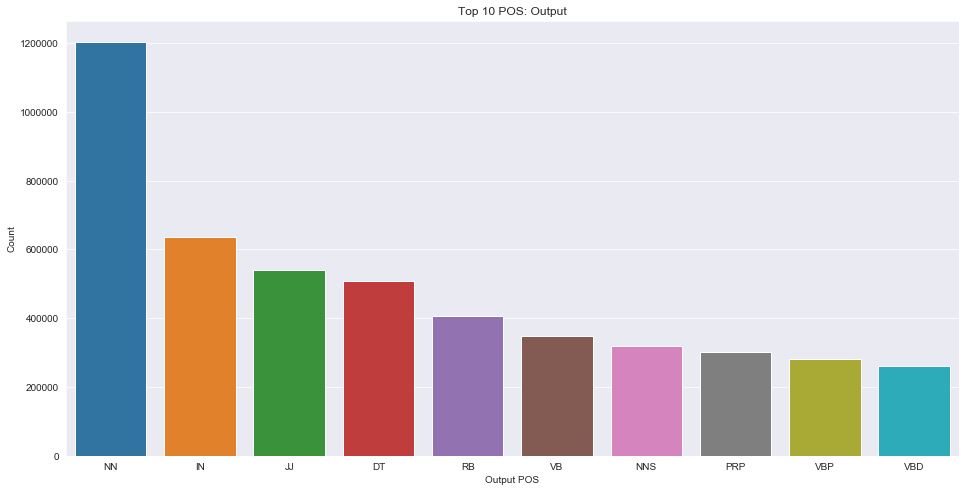

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(x = list(out_10[0]) , y= list(out_10[1]))
plt.title("Top 10 POS: Output")
plt.xlabel("Output POS")
plt.ylabel("Count")
plt.show()


## Observation:
Ref: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
* This show part of speech being used for maximum number of times is Noun(NN) followed by Preposition(IN).
* The overall numbers of parts of speech remains the same for input and output sentences but the nubers vary in NNS(Noun, plural) and PRP(personal pronouns)

In [21]:
df[["processed_input","processed_output","y"]].to_csv("/content/drive/MyDrive/Colab Notebooks/cs2/processed_data.csv",index=False)